<a href="https://colab.research.google.com/github/sayan0506/Deep-Learning-for-Drunks-Detection-with-Infrared-Camera/blob/main/Deep_Learning_for_Multi_Class_Drunks_Detection_with_Infrared_Camera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning for Drunks Detection with Infrared Camera Keras implementation**

The task here is is to build a classifier that can classify for a given image as sober or mild drunk or drunk.  In order to train or test, we can consider all four, front, side etc. at once to classify whether drunk or sober. Detailed problem statement can be found [here](https://docs.google.com/document/d/1cFWjsTds1tODVCGt5Cg-ozIjxOQg3p6jWmyV1RcB4u4/edit)

**Install Dependencies**

In [ ]:
# install wandb
!pip install wandb

## **Import Dependencies**

Importing necessary python modules

In [151]:
import os
import numpy as np
import random
import pandas as pd

from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf

from matplotlib import pyplot as plt
from matplotlib import cm
import cv2
# this is the imshow function which is supported by colab for opencv
from google.colab.patches import cv2_imshow

## **Mount Drive**

In [17]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **Environment Setup**

**Improve Reproducibility**

In [18]:
# improve reproducibility and make it more deterministic
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity")% 2**32 -1)

**GPU utilization**

In [19]:
# System Setup
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11457734888254662674, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17579576009947324988
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [20]:
# Checking GPU utilization
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found!')

print(f'Found GPU at: {device}')

Found GPU at: /device:GPU:0


**Setup wandb environment for trainining logs**

In [22]:
# import wandb dependencies

import wandb
from wandb.keras import WandbCallback

In [23]:
# authorize
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## **Dataset Load**

The dataset contains IR images captured from a thermal camera for 50 different people. For each image, the class labels are provided in filenames. The labeling nomenclature is explained along with the data capture process in the “[readme](https://docs.google.com/document/d/1DqlKALYfs9uyE4kB-TXJ8tAN3tKjTu2JL_HXAoga-XY/edit)".

**Shared dataset(accessed through mounted drive) link - [SOBER  -  DRUNK   DATABASE](https://drive.google.com/drive/folders/1P1UG36IzvN0QVntn3t2atph215QU_sG1)**


In [26]:
# dataset path
dataset_path = '/content/drive/MyDrive/DeepLearning_Assignment_Drunk_Sober_Classify'

print('Dataset Content\n')
# explore the content of dataset
os.chdir(dataset_path)
!ls

Dataset Content

 01_petros    12_loukas         23_vassiliskar	 34_alkis
 02_giorgos   13_manos	        24_rig		 35_thanasis
 03_vasil     14_lampros        25_nausika	 36_krod
 04_elpis     15_konstantinos   26_tsag		 37_vassilisA
 05_artemis   16_nikos	        27_theox	 38_christos
 06_tris      17_kwstas         28_frag		 39_anna
 07_thanos    18_dionisis       29_lia		 40_spiliop
 08_tzon      19_pasxalis       30_patty	 41_kalp
 09_giorg     20_nefeli         31_antonis	'Problem Statement.gdoc'
 10_konst     21_ilias	        32_vicky	 readme.gdoc
 11_takis     22_dimitris       33_iliasv	 sample_data_read.ipynb


## **Data Inspection**

Corresponding to each identity 4 different class samples available which corresponds to

1. Sober State
2. Drunk State 1
3. Drunk State 2
4. Drunk State 2

**Classifiers list**

In [83]:
classifiers_list = ['Sober state', 'Drunk state 1', 'Drunk state 2', 'Drunk state 3']

**Defining class dictionaries**

In [74]:
# list of all distionaries dictionaries
class_dict_list = []

# contains person-wise sober sample counts
sober_dict = {}
class_dict_list.append(sober_dict)
# contains person-wise drunk 1 sample counts
drunk1_dict = {}
class_dict_list.append(drunk1_dict)
# contains person-wise drunk 2 sample counts
drunk2_dict = {}
class_dict_list.append(drunk2_dict)
# contains person-wise drunk 3 sample counts
drunk3_dict = {}
class_dict_list.append(drunk3_dict)

**Analyze person-wise drunk samples available count**

In [99]:
# os.walk helps to walkthrough the entire folder one by one starting from base to each individual foler
for i, (_, dirs, files) in enumerate(os.walk(dataset_path)):
  # fetches list of drunk person folders
  drunk_person_list = dirs
  print(f'List of drunk {len(drunk_person_list)} person samples\n{drunk_person_list}\n')
  # counts total samples available class-wise for individual person 

  for identity in drunk_person_list:
    sober_list = []
    drunk1_list = []
    drunk2_list = []
    drunk3_list = []
    # walk through samples of each identity folder
    for sample in os.listdir(identity):
      # finding class index of the sample
      class_idx = int(sample[sample.find(identity)+len(identity)+1]) 
      # if sample for sober state
      if class_idx == 1:
        sober_list.append(sample)
      # if sample for drunk state 1  
      elif class_idx == 2:
        drunk1_list.append(sample)
      # if sample for drunk state 2  
      elif class_idx == 3:
        drunk2_list.append(sample)
      # if sample for drunk state 3  
      elif class_idx == 4:
        drunk3_list.append(sample)
    
    # adding samples to consecuetive class dictionary
    sober_dict[identity] = sober_list
    drunk1_dict[identity] = drunk1_list
    drunk2_dict[identity] = drunk2_list
    drunk3_dict[identity] = drunk3_list
  break

  #a.append(len(files))

List of drunk 41 person samples
['39_anna', '12_loukas', '29_lia', '05_artemis', '41_kalp', '21_ilias', '40_spiliop', '13_manos', '16_nikos', '18_dionisis', '28_frag', '02_giorgos', '06_tris', '01_petros', '24_rig', '14_lampros', '34_alkis', '37_vassilisA', '10_konst', '20_nefeli', '26_tsag', '09_giorg', '03_vasil', '08_tzon', '38_christos', '27_theox', '25_nausika', '17_kwstas', '15_konstantinos', '19_pasxalis', '35_thanasis', '11_takis', '30_patty', '23_vassiliskar', '32_vicky', '04_elpis', '07_thanos', '36_krod', '33_iliasv', '31_antonis', '22_dimitris']



**Visualize the person-wise class distribution**

Total samples available for Sober state - 164

Total samples available for Drunk state 1 - 164

Total samples available for Drunk state 2 - 161

Total samples available for Drunk state 3 - 160



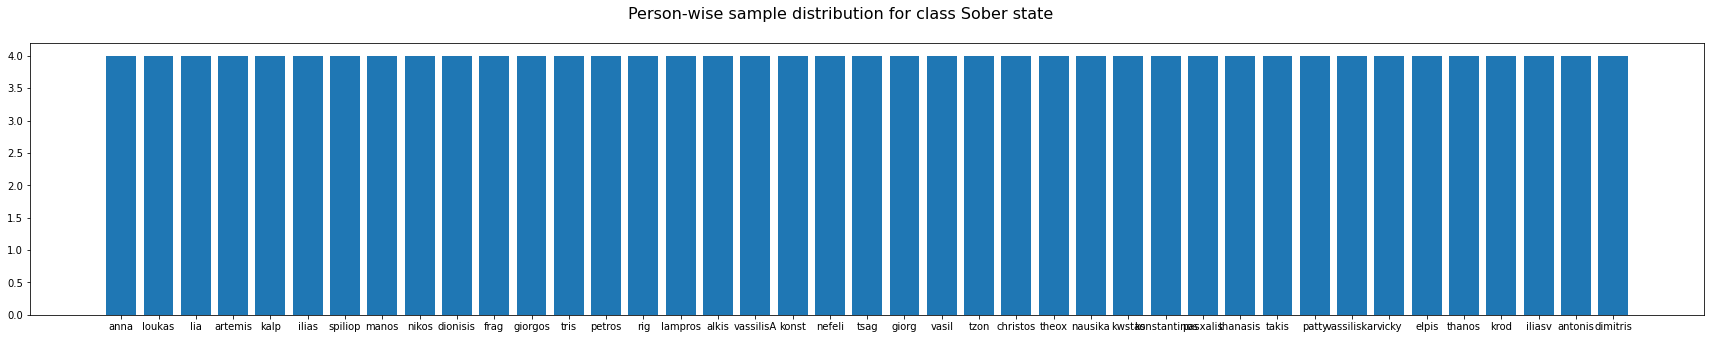

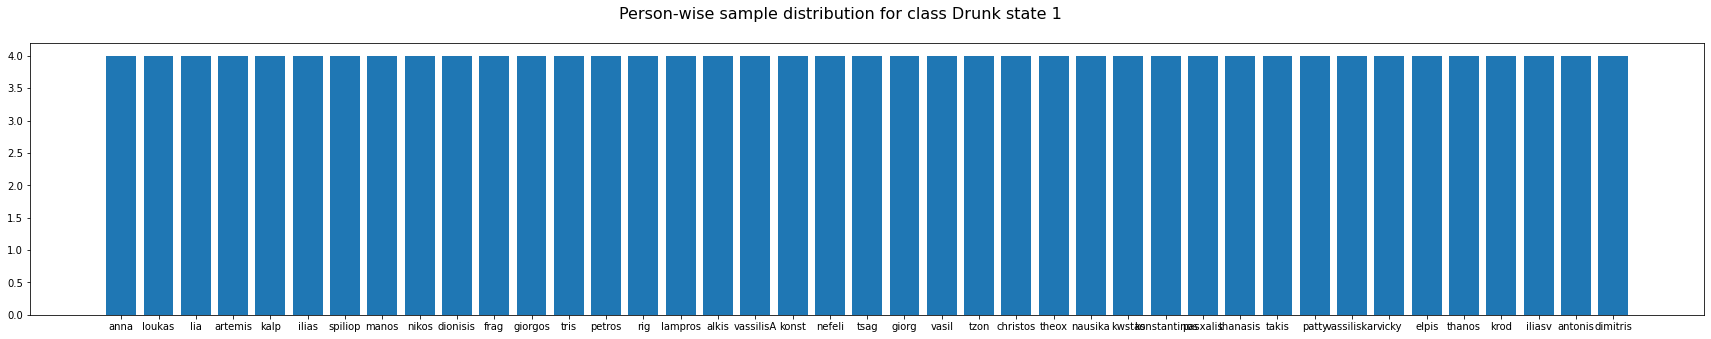

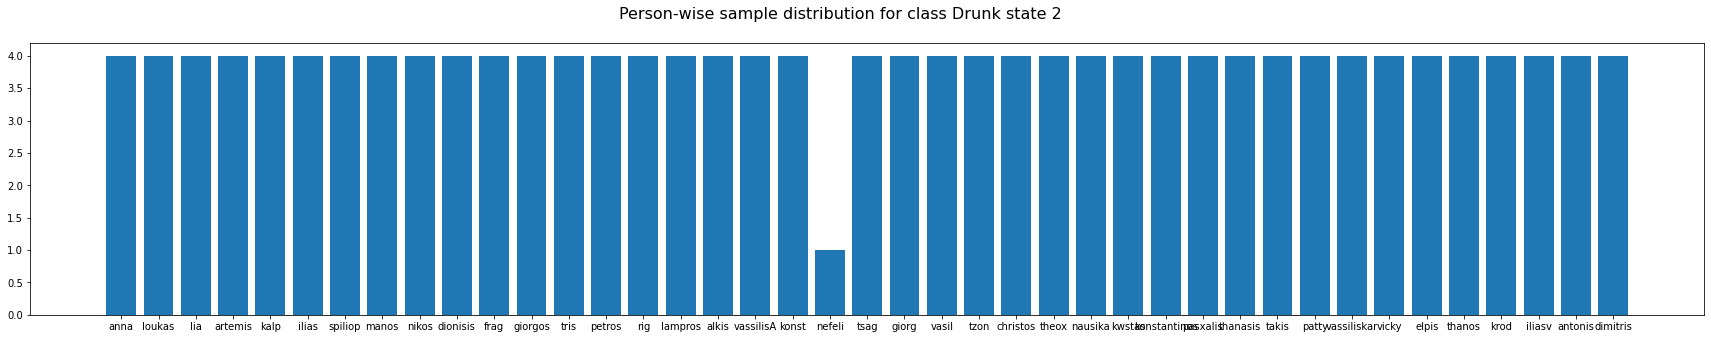

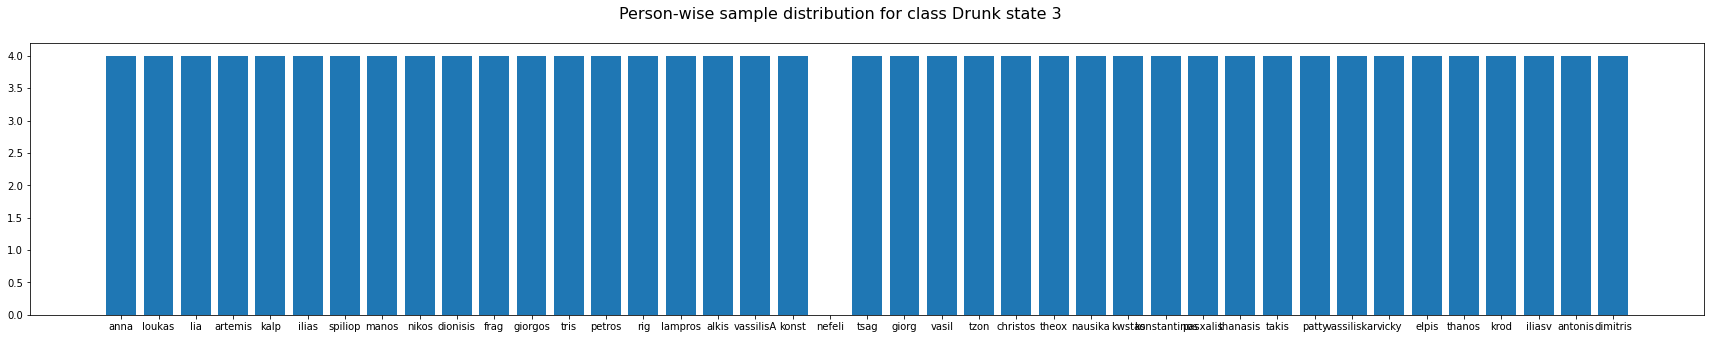

Total 649 image samples are available in the dataset!


In [123]:
# counts total image smple available
sample_total = 0
for i, class_dict in enumerate(class_dict_list):
  # list of identities
  identities = [key[3:] for key in list(class_dict.keys())]
  # list of person-wise sample counts for individual classes 
  samples_count = [len(sample_list) for sample_list in class_dict.values()]
  sample_total += sum(samples_count)
  print(f'Total samples available for {classifiers_list[i]} - {sum(samples_count)}\n')  
  # define figure plot
  fig = plt.figure(figsize=(30,5))
  fig.suptitle(f'Person-wise sample distribution for class {classifiers_list[i]}', fontsize = 16)
  plt.tight_layout()
  plt.bar(range(len(identities)), samples_count)
  plt.xticks(range(len(identities)), identities)

plt.show()

print(f'Total {sample_total} image samples are available in the dataset!')

From the data analysis it can be found that for **Nefeli**, **Drunk 3** state is not available, and **Drunk 2** state has only 1 sample available.

## **Data Preparation**

#### **Preparing Image Dataframe**

In [98]:
# image dataframe
img_df = pd.DataFrame(columns=['Image', 'Label'])

**Fetching Samples Path in the image dataframe**

In [129]:
# counts total samples
sample_count = 0
for i, class_dict in enumerate(class_dict_list):
  print(f'Loading data for {classifiers_list[i]}...')
  # list of person-wise samples for individual classes and paths 
  for id_path, sample_list in zip(class_dict.keys(), class_dict.values()):
    # defining the identity path
    class_id_path =os.path.join(dataset_path, id_path)
    # fetching images path to image daraframe
    for image in sample_list:
      # note: it's checed that no others files like .dstore in image folders, so no such check is addded here  
      # checks whether '.tif' is available
      if image.endswith(".tif") == True or image.endswith(".TIF") == True:  
        # defines image path
        img_path = os.path.join(class_id_path, image)
        # loading image path, class labels
        img_df.loc[sample_count, 'Image'], img_df.loc[sample_count, 'Label'] = img_path, classifiers_list[i] 
        sample_count+=1

# assertion check of image samples fetch
assert sample_total == img_df.shape[0]
print(f'\nCheck passed, {img_df.shape[0]} sample are fetched successfully!\nImage dataframe demo\n')
img_df

Loading data for Sober state...
Loading data for Drunk state 1...
Loading data for Drunk state 2...
Loading data for Drunk state 3...

Check passed, 649 sample are fetched successfully!
Image dataframe demo



,Image,Label
0,/content/drive/MyDrive/DeepLearning_Assignment...,Sober state
1,/content/drive/MyDrive/DeepLearning_Assignment...,Sober state
2,/content/drive/MyDrive/DeepLearning_Assignment...,Sober state
3,/content/drive/MyDrive/DeepLearning_Assignment...,Sober state
4,/content/drive/MyDrive/DeepLearning_Assignment...,Sober state
...,...,...
644,/content/drive/MyDrive/DeepLearning_Assignment...,Drunk state 3
645,/content/drive/MyDrive/DeepLearning_Assignment...,Drunk state 3
646,/content/drive/MyDrive/DeepLearning_Assignment...,Drunk state 3
647,/content/drive/MyDrive/DeepLearning_Assignment...,Drunk state 3


#### **Train, Validation, Test split**

We are preparing train, valid, test split of the dataframes so that we can implement **stratified train-test split** in the **image_data_generator**.

In [130]:
# train dataframe
train_df = pd.DataFrame(columns=['Image', 'Label'])
# validation main dataframe for valid-test split
valid_main_df = pd.DataFrame(columns=['Image', 'Label'])
# validation dataframe
valid_df = pd.DataFrame(columns=['Image', 'Label'])
# test dataframe
test_df = pd.DataFrame(columns=['Image', 'Label'])

**Defining split ratio and other metadata**

We are taking [train:valid:test] **split ratio** as - **[0.9:0.05:0.05]**

In [145]:
# validation split
val_ratio = 0.10
# test split
test_ratio = 0.5

# fetch only image paths to image ids
img_ids = img_df.loc[:,'Image']

# fetch only labels to label ids
label_ids = img_df.loc[:,'Label']

**Defining Train, Valid, Test split**

Train-Valid_main split

In [146]:
# without shuffling startification is not possible
train_df['Image'], valid_main_df['Image'], train_df['Label'], valid_main_df['Label'] = train_test_split(img_ids, label_ids,
                                                                                                        test_size = val_ratio,
                                                                                                        random_state = 28,
                                                                                                        stratify = label_ids,
                                                                                                        shuffle = True
                                                                                                        )

Valid-Test split

In [147]:
valid_df['Image'], test_df['Image'], valid_df['Label'], test_df['Label'] = train_test_split(valid_main_df['Image'], valid_main_df['Label'],
                                                                                            test_size = test_ratio,
                                                                                            random_state = 28,
                                                                                            stratify = valid_main_df['Label'],
                                                                                            shuffle = True) 

In [148]:
print(f'Train dataframe shape {train_df.shape}')
print(f'Validation dataframe shape {valid_df.shape}')
print(f'Test dataframe shape {test_df.shape}')

Train dataframe shape (584, 2)
Validation dataframe shape (32, 2)
Test dataframe shape (33, 2)


**Startification Check**

Defining visualization function for stratified train test split

In [150]:
# startified vis func
def distribution_vis_check(train, valid, test):
  '''
  Target distribution
  '''
  xdf = [train.index, valid.index, test.index]
  ydf = [train.values, valid.values, test.values]
  label = ['Train Distribution', 'validation Distribution', 'Test Distribution']
  fig = plt.figure(figsize=(20,5))
  for i in range(len(xdf)):
    fig.add_subplot(1, len(xdf), i+1)
    sns.barplot(x = xdf[i], y = ydf[i])
    plt.xlabel(label[i], fontsize = 16)

Startification result**

In [173]:
print('Startification result-')
print('Train set -\n{}'.format(train_df['Label'].value_counts()))
print('Validation set -\n{}'.format(valid_df['Label'].value_counts()))
print('Test set -\n{}'.format(test_df['Label'].value_counts()))


Startification result-
Train set -
Drunk state 1    148
Sober state      147
Drunk state 2    145
Drunk state 3    144
Name: Label, dtype: int64
Validation set -
Drunk state 1    8
Drunk state 2    8
Drunk state 3    8
Sober state      8
Name: Label, dtype: int64
Test set -
Sober state      9
Drunk state 1    8
Drunk state 2    8
Drunk state 3    8
Name: Label, dtype: int64


**Startification Distribution Visualize**

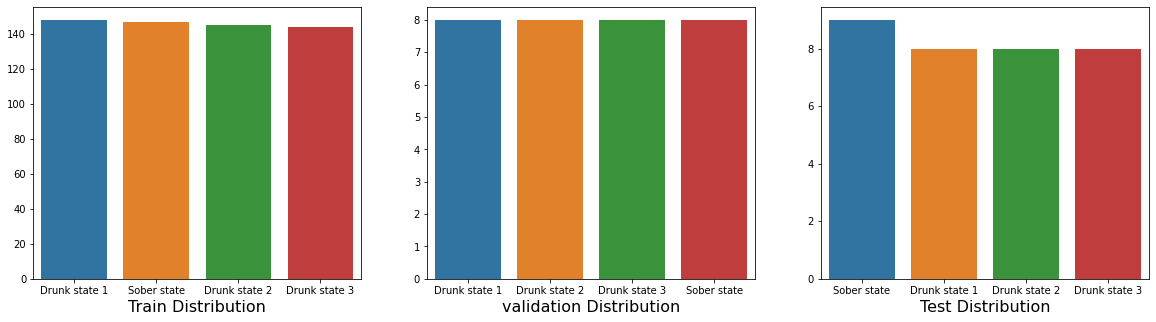

In [156]:
distribution_vis_check(train_df['Label'].value_counts(), valid_df['Label'].value_counts(), test_df['Label'].value_counts())

In [86]:
def img_preprocess(path):
  # read the infrared image from the given path in unchanged mode
  img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

  # convert from BGR to RGB format
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  # convert to jet colormap by converting to uint8 default format that is acceted by opencv 4.5.2
  img = cv2.applyColorMap(img.astype('uint8'), cv2.COLORMAP_JET)

  # convert to float32
  img = img.astype(np.float32)

  return img

In [110]:
img = img_preprocess('/content/drive/MyDrive/DeepLearning_Assignment_Drunk_Sober_Classify/01_petros/01_petros_3_r_M_20_71_032.tif')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


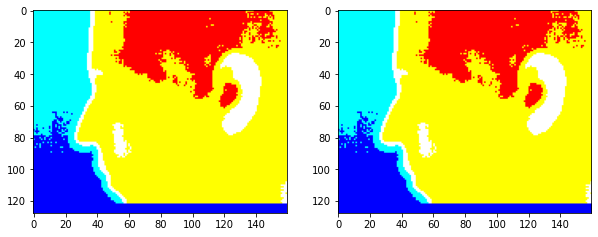

In [109]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
fig.add_subplot(122)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [94]:
cv2.imwrite('new.jpg', img)

True

In [105]:
im1 = plt.imread('new.jpg')

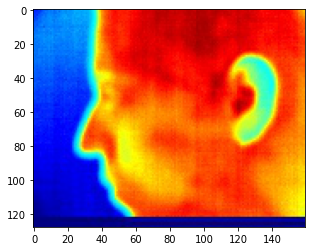

In [106]:
plt.imshow(im1)

In [107]:
im1.dtype

dtype('uint8')